# The Principles of DNA Sequence Compression

## Quantification of Information

Information theory is based on the observation that knowing that a likely event has occurred is less informative than knowing that an unlikely event has occurred. A quantification of information should have the following properties:

- Likely events should have a low information content, and events that are certain to occur should have no information content at all. Less likely events should have a higher information content.
- Independent events should have additive information content.

The self-information of an event $x$ is hence defined as

$$I(x)=-\log{}P(x).$$

By using the base-2 logarithm, the unit of self-information is bit. Hence, one bit is the amount of information gained by observing an event of probability $\frac{1}{2}$.

Self-information deals only with a single event $x$. By computing the expectation of the self-information with respect to the entire probability distribution $P(\text{x})$ we obtain the entropy

$$H(\text{x})=\mathbb{E}_{\text{x}\sim{}P}[I(x)]=-\mathbb{E}_{\text{x}\sim{}P}[\log{}P(x)]=-\sum_{x}P(x)\log{}P(x).$$

The entropy gives the average information that is expected in an event $x$ drawn from probability distribution $P(\text{x})$.

**Experiment** &mdash; Compute the entropy of the sequences `AAAA`, `AACC`, `ACGT`.

In [1]:
import entropy

sequences = ['AAAA', 'AACC', 'ACGT']
for s in sequences:
    eta = entropy.entropy(s)
    print("Entropy of '{}': {:.2f} bit/symbol".format(s, round(eta, 2)))

Entropy of 'AAAA': 0.00 bit/symbol
Entropy of 'AACC': 1.00 bit/symbol
Entropy of 'ACGT': 2.00 bit/symbol


## Na&iuml;ve Compression of DNA Sequencing Reads

The FASTQ format is the de-facto standard for the storage of reads, i.e., nucleotide sequences, including corresponding quality scores.

Each read is represented by a single FASTQ record, which consists of four lines:
- The first line contains the read identifier. It starts with `@`. Typically, sequencing machine vendors generate read identifiers in a proprietary systematic way.
- The second line contains the nucleotide sequence, where each nucleotide is represented with a single ASCII character.
- The third line starts with `+` and contains an optional description. Usually this line is left empty; it then only contains `+` as separator between the nucleotide sequence and the quality scores.
- The fourth line contains the quality scores. A quality score is a value indicating the confidence in a base call.

We can convert a FASTQ record (four lines) into a dictionary with the following function:

In [2]:
def fastq_lines_to_dict(lines):
    keys = ['id', 'seq', 'desc', 'qual']
    return {key: value for key, value in zip(keys, lines)}

**Experiment** &mdash; Parse the FASTQ file `example.fastq`.

In [3]:
file_name = 'example.fastq'
records = []

with open(file_name, 'r') as f:
    lines = []
    for line in f:
        lines.append(line.rstrip())
        if (len(lines)) == 4:
            records.append(fastq_lines_to_dict(lines))
            lines = []

for r in records:
    print('Record: {}'.format(str(r)))

Record: {'id': '@id0', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}
Record: {'id': '@id1', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}
Record: {'id': '@id2', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}
Record: {'id': '@id3', 'seq': 'GATTTGGGGTTCAAAGCAGTATCGATCAAATA', 'desc': '+', 'qual': "!''*((((***+))%%%++)(%%%%).1***-"}


**Experiment** &mdash; Concatenate all records from `example.fastq`. Compute the entropy and the maximum (worst-case) compressed size in bit and byte.

In [4]:
import math

seq = ''
for r in records:
    seq += r['seq']
# print('Concatenated sequence: {}'.format(seq))
seq_len = len(seq)
print('Concatenated sequence length: {} byte'.format(seq_len))

eta = entropy.entropy(seq)
print("Entropy: {:.2f} bit/symbol".format(round(eta, 2)))

max_size_in_bit = math.ceil(eta * seq_len)
max_size_in_byte = math.ceil(max_size_in_bit / 8)
print('Maximum compressed size: {} bit = {} byte'.format(max_size_in_bit, max_size_in_byte))
print('Worst-case compression ratio: {:.1f}x'.format(seq_len / max_size_in_byte))

Concatenated sequence length: 128 byte
Entropy: 1.92 bit/symbol
Maximum compressed size: 246 bit = 31 byte
Worst-case compression ratio: 4.1x


**Experiment** &mdash; Use gzip to beat the estimated worst-case compression.

In [5]:
import gzip

seq = ''
for r in records:
    seq += r['seq']
seq = seq * 10
seq_len = len(seq)

print('Uncompressed sequence length: {}'.format(seq_len))
compressed_seq = gzip.compress(data=bytes(seq, 'utf-8'))
compressed_seq_len = len(compressed_seq)
print('Compressed sequence length: {}'.format(compressed_seq_len))

decompressed_seq = gzip.decompress(data=compressed_seq)
decompressed_seq = decompressed_seq.decode('utf-8')

if decompressed_seq == seq:
    print('The decompressed sequence is equal to the original sequence.')
else:
    print('Error: The decompressed sequence is *not* equal to the original sequence.')

print('Compression ratio: {:.2f}x'.format(seq_len / compressed_seq_len))

Uncompressed sequence length: 1280
Compressed sequence length: 56
The decompressed sequence is equal to the original sequence.
Compression ratio: 22.86x


## Using Alignment to Improve Compression of DNA Sequence Reads

The Needleman-Wunsch algorithm finds the optimal **global** alignment (end-to-end) between two sequences. It consists of the following steps:

- Construct the grid
- Choose a scoring system (here we use the original scoring system assigning a score of 1 to a match and a score of -1 to a mismatch or indel/gap)
- Fill in the scoring matrix (and construct the pointer matrix on the way)
- Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\begin{cases}F(i-1,j-1)+s(x_i,y_i),\\F(i-1,j)-d,\\F(i,j-1)-d.\end{cases}
$$

The following image illustrates both the scoring and pointer matrixes.

![Needleman-Wunsch pairwise sequence alignment](Needleman-Wunsch_pairwise_sequence_alignment.png)

**Experiment** &mdash; Perform the global alignment between the sequences `GATTACA` and `CATACCCA`. Plot the scoring matrix and the warping path.

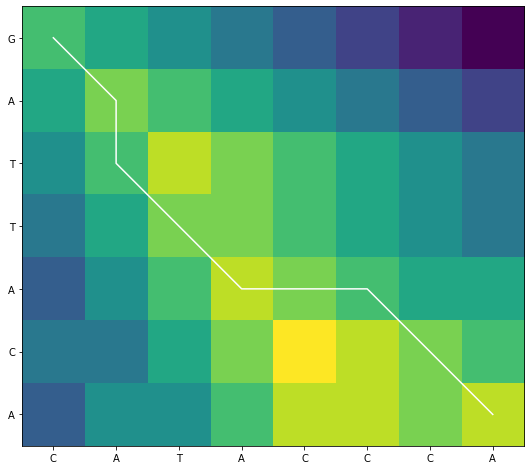

In [6]:
import alignment
import matplotlib.pyplot as plt

x = 'GATTACA'
y = 'CATACCCA'
x_aligned, y_aligned, path_x, path_y, F = alignment.align(x=x, y=y, mode='global')

%matplotlib inline
plt.figure(figsize=[9, 9])
plt.imshow(F)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
# plt.colorbar()
plt.plot(path_y, path_x, 'w')
plt.show()

The Smith-Waterman algorithm finds the optimal **local** alignment between two sequences. It is a variation of the Needleman-Wunsch algorithm. The three main differences are:

|              | Smith-Waterman algorithm | Needleman-Wunsch algorithm              |
|--------------|--------------------------|-----------------------------------------|
Initialization | First row/column = 0     | First row/column subject to gap penalty |
Scoring        | Negative scores are set to 0 | Scores can be negative |
Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

**Experiment** &mdash; Perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`. Plot the scoring matrix and the warping path.

alignment.align: multiple (2) possible traceback starts, choosing [ 5 16]


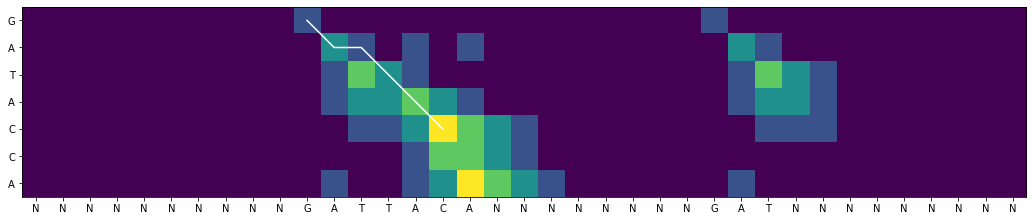

In [7]:
x = 'GATACCA'
y = 'NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN'
x_aligned, y_aligned, path_x, path_y, F = alignment.align(x=x, y=y, mode='local')

%matplotlib inline
plt.figure(figsize=[18, 9])
plt.imshow(F)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(path_y, path_x, 'w')
plt.show()

**Experiment** &mdash; Sample 10 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [8]:
import random

ref = 'GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA'

num_reads = 10
reads = []
min_read_len = 5
max_read_len = 10

for i in range(num_reads):
    range_acquired = False
    start = 0
    end = 0
    while not range_acquired:
        start = random.randrange(len(ref))
        end = random.randrange(len(ref))
        if start > end:
            continue
        if (end - start+1) < min_read_len:
            continue
        if (end - start+1) > max_read_len:
            continue
        range_acquired = True
    read = ref[start:end+1]
    print('Read {} (range: [{:3d} {:3d}], length: {:3d}): {} '.format(i, start, end, len(read), read))
    reads.append(read)    

Read 0 (range: [ 18  26], length:   9): GTATCGATC 
Read 1 (range: [  9  16], length:   8): TTCAAAGC 
Read 2 (range: [ 16  21], length:   6): CAGTAT 
Read 3 (range: [ 52  59], length:   8): CACAGTTT 
Read 4 (range: [ 38  43], length:   6): CCATTT 
Read 5 (range: [ 15  22], length:   8): GCAGTATC 
Read 6 (range: [ 32  36], length:   5): GTAAA 
Read 7 (range: [ 19  25], length:   7): TATCGAT 
Read 8 (range: [ 13  17], length:   5): AAGCA 
Read 9 (range: [ 38  45], length:   8): CCATTTGT 


**Experiment** &mdash; Add some noise to the reads.

In [9]:
def add_noise(read):
    choices = ['A', 'C', 'G', 'T']
    noisy_read = ''
    for base in read:
        if random.randint(a=0, b=7) == 0:
            noisy_base = random.choice([c for c in choices if c != base])
            noisy_read += noisy_base
        else:
            noisy_read += base
    return noisy_read

noisy_reads = []
for read in reads:
    noisy_read = add_noise(read)
    print('Added noise: {:20s} -> {:20s}'.format(read, noisy_read))
    noisy_reads.append(noisy_read)

Added noise: GTATCGATC            -> GCATGGATG           
Added noise: TTCAAAGC             -> TACAAAGC            
Added noise: CAGTAT               -> CAGTAT              
Added noise: CACAGTTT             -> CACAGTTT            
Added noise: CCATTT               -> ACATTT              
Added noise: GCAGTATC             -> GCAGTATC            
Added noise: GTAAA                -> GCAAA               
Added noise: TATCGAT              -> TATAGAT             
Added noise: AAGCA                -> AGGCA               
Added noise: CCATTTGT             -> CCGTTCGT            


**Experiment** &mdash; Align the noisy reads locally to the reference sequence. Compute the residual of each noisy read w.r.t. the reference sequence.

alignment.align: multiple (3) possible traceback starts, choosing [ 8 26]
3 bases were clipped from the alignment
Noisy read            : GCATGGATG
Aligned read          : ATGGAT
Reference subsequence : ATCGAT
Residual              : mmGmmm


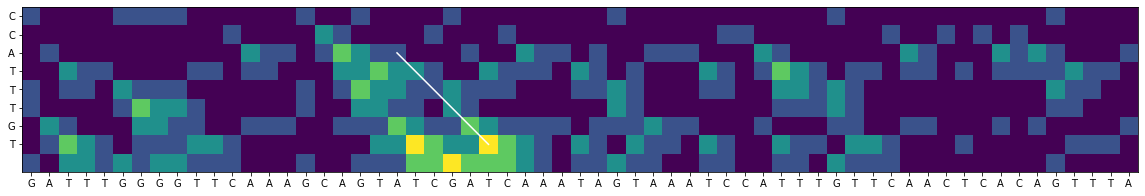

2 bases were clipped from the alignment
Noisy read            : TACAAAGC
Aligned read          : CAAAGC
Reference subsequence : CAAAGC
Residual              : mmmmmm


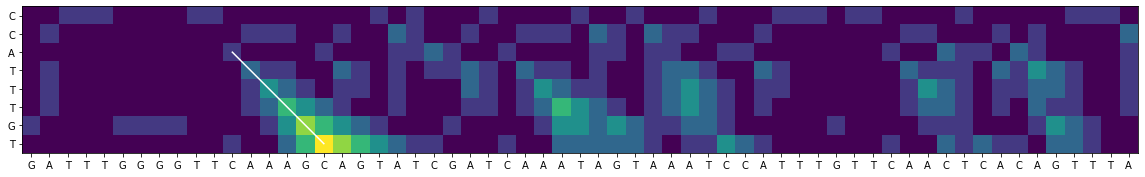

0 bases were clipped from the alignment
Noisy read            : CAGTAT
Aligned read          : CAGTAT
Reference subsequence : CAGTAT
Residual              : mmmmmm


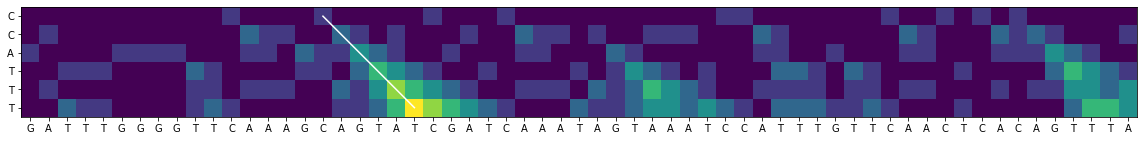

0 bases were clipped from the alignment
Noisy read            : CACAGTTT
Aligned read          : CACAGTTT
Reference subsequence : CACAGTTT
Residual              : mmmmmmmm


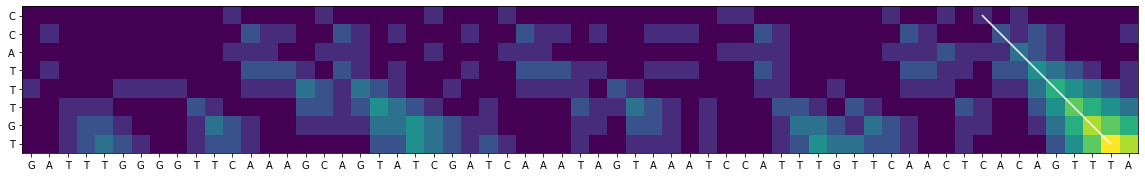

alignment.align: multiple (2) possible traceback starts, choosing [ 6 60]
0 bases were clipped from the alignment
Noisy read            : ACATTT
Aligned read          : ACA-TTT
Reference subsequence : ACAGTTT
Residual              : mmm-mmm


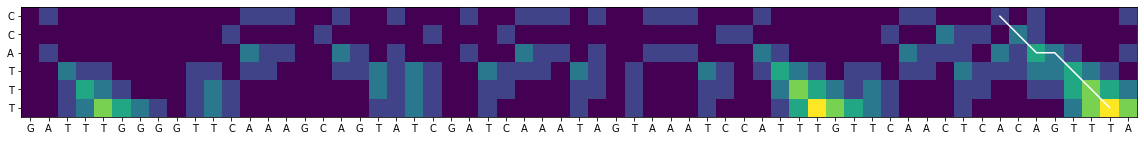

0 bases were clipped from the alignment
Noisy read            : GCAGTATC
Aligned read          : GCAGTATC
Reference subsequence : GCAGTATC
Residual              : mmmmmmmm


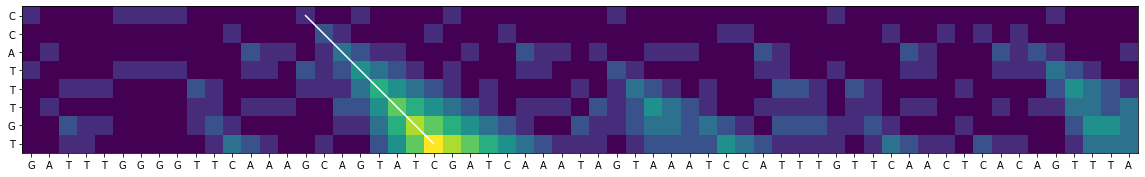

alignment.align: multiple (2) possible traceback starts, choosing [ 5 30]
1 bases were clipped from the alignment
Noisy read            : GCAAA
Aligned read          : CAAA
Reference subsequence : CAAA
Residual              : mmmm


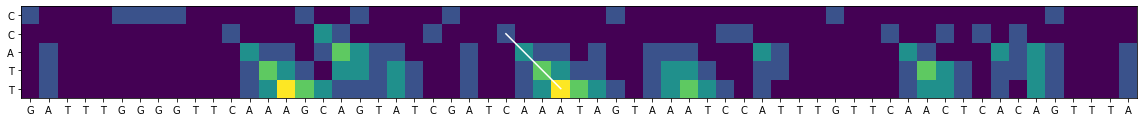

0 bases were clipped from the alignment
Noisy read            : TATAGAT
Aligned read          : TATAGAT
Reference subsequence : TATCGAT
Residual              : mmmAmmm


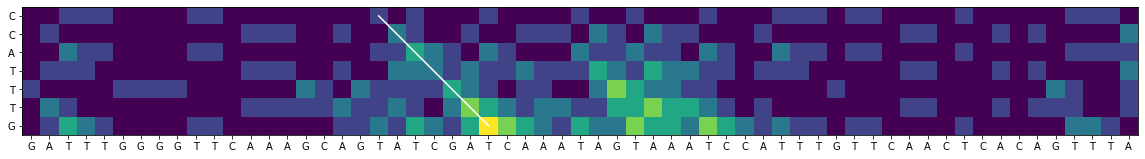

2 bases were clipped from the alignment
Noisy read            : AGGCA
Aligned read          : GCA
Reference subsequence : GCA
Residual              : mmm


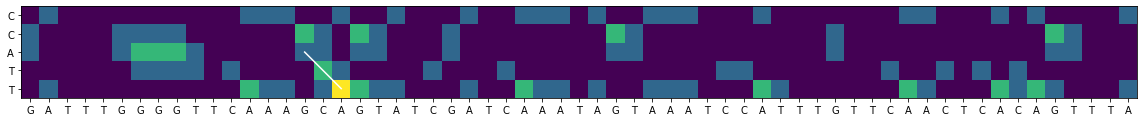

alignment.align: multiple (5) possible traceback starts, choosing [ 6 48]
4 bases were clipped from the alignment
Noisy read            : CCGTTCGT
Aligned read          : GTTC
Reference subsequence : GTTC
Residual              : mmmm


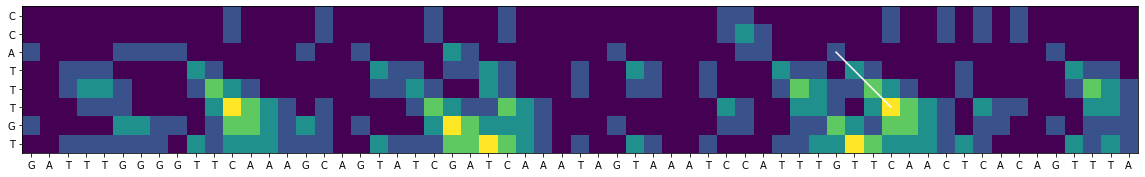

In total, 12 bases were clipped


In [10]:
diffs = []
num_clipped_bases = 0

for r in noisy_reads:
    read_aligned, ref_aligned, path_x, path_y, F = alignment.align(x=r, y=ref, mode='local')

    read_aligned_without_gaps = read_aligned.replace('-','')
    print('{} bases were clipped from the alignment'.format(len(r) - len(read_aligned_without_gaps)))
    num_clipped_bases += len(r) - len(read_aligned_without_gaps)
    
    ref_substring = ref[path_y[0]:(path_y[-1] + 1)]
    diff = ''
    for i in range(len(read_aligned)):
        if i >= len(ref_substring) or read_aligned[i] != ref_substring[i]:
            diff += read_aligned[i]
        else:
            diff += 'm'
    diffs.append(diff)
    
    print('Noisy read            : {}'.format(r))
    print('Aligned read          : {}'.format(read_aligned))
    print('Reference subsequence : {}'.format(ref_substring))
    print('Residual              : {}'.format(diff))
    
    %matplotlib inline
    plt.figure(figsize=[20,10])
    plt.imshow(F)
    plt.xticks(ticks=range(len(ref)), labels=ref)
    plt.yticks(ticks=range(len(read)), labels=read)
    #plt.colorbar()
    plt.plot(path_y, path_x, 'w')
    plt.show()
    
print('In total, {} bases were clipped'.format(num_clipped_bases))

**Experiment** &mdash; Calculate the entropy of the noisy reads and of the residual (plus an estimate for the clipped bases).

In [11]:
concatenated_noisy_reads = ''.join(noisy_reads)
eta = entropy.entropy(concatenated_noisy_reads)
print('Entropy (noisy reads): {:.2f} bit/symbol'.format(round(eta, 2)))
max_size_in_bit = math.ceil(eta * len(concatenated_noisy_reads))
max_size_in_byte = math.ceil(max_size_in_bit / 8)
print('Maximum compressed size (noisy reads): {} bit = {} byte'.format(max_size_in_bit, max_size_in_byte))
           
concatenated_residuals = ''.join(diffs)
eta = entropy.entropy(concatenated_residuals)
print('Entropy (residuals): {:.2f} bit/symbol'.format(round(eta, 2)))
concatenated_residuals_max_size_in_bit = math.ceil(eta * len(concatenated_residuals))
clipped_bases_max_size_in_bit = num_clipped_bases * 2
max_size_in_bit = concatenated_residuals_max_size_in_bit + clipped_bases_max_size_in_bit
max_size_in_byte = math.ceil((concatenated_residuals_max_size_in_bit + clipped_bases_max_size_in_bit) / 8)
print('Maximum compressed size (residuals + clipped bases): {} + {} bit = {} bit = {} byte'.format(concatenated_residuals_max_size_in_bit, clipped_bases_max_size_in_bit, max_size_in_bit, max_size_in_byte))

Entropy (noisy reads): 1.98 bit/symbol
Maximum compressed size (noisy reads): 139 bit = 18 byte
Entropy (residuals): 0.37 bit/symbol
Maximum compressed size (residuals + clipped bases): 22 + 24 bit = 46 bit = 6 byte
